In [1]:
import os
import sys
import trace
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import norm
from scipy.optimize import curve_fit
from matplotlib import cm, ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from typing import List, Dict, Tuple

root_dir = os.environ.get("ROOT_PATH")
if not root_dir in sys.path: sys.path.append(root_dir)

from src.utils.constants import *
from src.utils.CosmoFunc import *
from src.utils.logging_config import get_logger

from src.filepaths import *

pvhub_dir = os.environ.get('PVHUB_DIR_PATH')
if not pvhub_dir in sys.path: sys.path.append(pvhub_dir)
from pvhub import * # type: ignore

from dotenv import load_dotenv
load_dotenv(override=True)

# Get environment variables from .env file
ROOT_PATH = os.environ.get('ROOT_PATH')
SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
COMPLETENESS_SETTING = int(os.environ.get('COMPLETENESS_SETTING'))
FP_FIT_METHOD = int(os.environ.get('FP_FIT_METHOD'))

# Create boolean from FP_FIT_METHOD value
USE_FULL_FN = True if FP_FIT_METHOD == 0 else False

### Identifying Outliers

In [2]:
def get_outlier_thresholds(x, k=5.0):
    # Select inliers using MAD
    median_x = np.median(x)
    MAD_x = np.median(np.absolute(x - median_x))
    lower_ = median_x - k * MAD_x
    upper_ = median_x + k * MAD_x
    x_inliers = x[(x >= lower_) & (x <= upper_)]

    # Calculate standard deviation using the assumed inliers
    mean_ = np.mean(x_inliers)
    std_ = np.std(x_inliers)
    lower_ = mean_ - 6 * std_
    upper_ = mean_ + 6 * std_

    return lower_, upper_

# Load mock fits
mock_fits = pd.read_csv("../artifacts/mock_fits/smin_setting_1/fp_fit_method_0/lamost_fit_with_partial_fn.csv")
fp_cols = [col for col in mock_fits.columns if col != "mock_id"]

# Identify outliers
outlier_ids = []
for col in fp_cols:
    x = mock_fits[col].values
    x_min, x_max = get_outlier_thresholds(x)

    # Get all ids
    outlier_ids += mock_fits[(mock_fits[col] <= x_min) | (mock_fits[col] >= x_max)]["mock_id"].tolist()
    outlier_ids = list(set(outlier_ids))

print(f"Mock ID producing outlying FP fits: {outlier_ids}")

Mock ID producing outlying FP fits: [737, 130]


In [4]:
mock_fits[mock_fits["sigma2"] > 0.32]

,mock_id,a,b,rmean,smean,imean,sigma1,sigma2,sigma3
329,330,1.507449,-0.955239,-0.078602,2.161337,3.312428,0.050217,0.321403,0.167763
736,737,1.414521,-0.939907,-0.085137,2.145107,3.302058,0.052221,0.331092,0.169962


### Plot mocks producing outlying fits

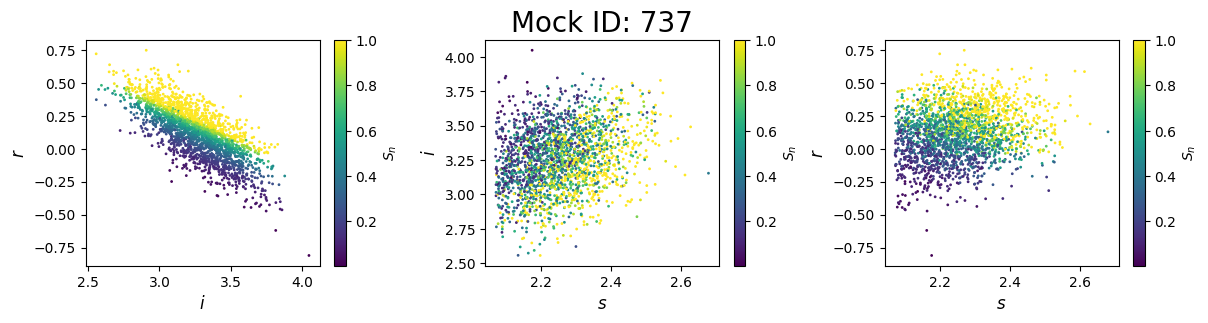

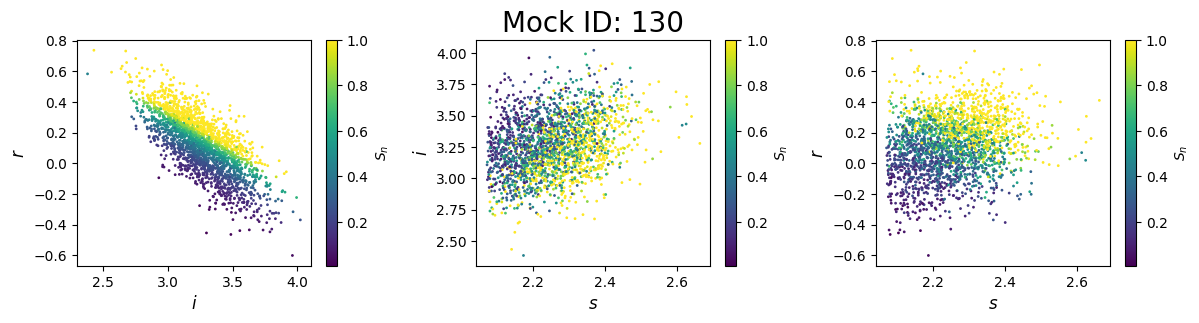

In [35]:
# Load mock data
df = pd.read_csv("../data/mocks/mock_galaxies/lamost_mocks_smin_1_fp_fit_method_0.txt", delim_whitespace=True)
df["mock_id"] = df["#mockgal_ID"].apply(lambda x: int(x.split("_")[1]))

for id in outlier_ids:
    # print()
    # print("-" * 50)
    # print(f"Mock ID: {id}")
    df_ = df[df["mock_id"] == id]
    # df_ = df_[df_["Sprob"] > 0.005]

    fig, axs = plt.subplots(ncols=3, figsize=(FIGURE_WIDTH * 3 / 2, FIGURE_HEIGHT / 1.5))
    combos = [("i", "r"), ("s", "i"), ("s", "r")]
    for i, combo in enumerate(combos):
        ax = fig.axes[i]
        col_x, col_y = combo
        scatter = ax.scatter(df_[col_x], df_[col_y], c=df_["Sprob"], s=1, cmap='viridis')
        fig.colorbar(scatter, ax=ax, label=r'$S_n$')

        ax.set_xlabel(rf"${col_x}$", fontsize=12)
        ax.set_ylabel(rf"${col_y}$", fontsize=12)

        if i == 1:
            ax.set_title(f"Mock ID: {id}", fontsize=20)

    fig.tight_layout()

(array([  1.,  21.,  89., 241., 471., 587., 484., 196.,  41.,  11.]),
 array([-0.602 , -0.4681, -0.3342, -0.2003, -0.0664,  0.0675,  0.2014,
         0.3353,  0.4692,  0.6031,  0.737 ]),
 <BarContainer object of 10 artists>)

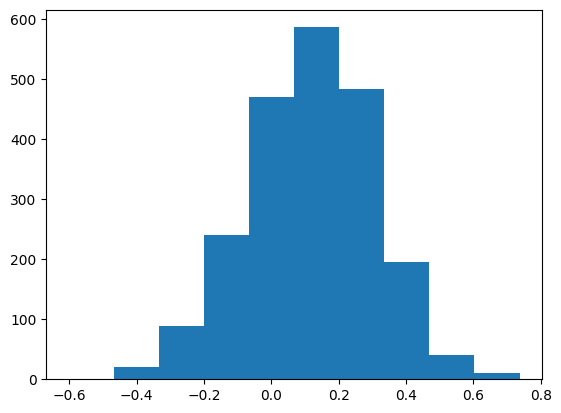

In [41]:
df = pd.read_csv("../data/mocks/mock_galaxies/lamost_mocks_smin_1_fp_fit_method_0.txt", delim_whitespace=True)
df["mock_id"] = df["#mockgal_ID"].apply(lambda x: int(x.split("_")[1]))
df = df[df["mock_id"] == 130]
# df[df["r"] < -0.5]
# df[df["Sprob"] <= 0.041]
# plt.hist(df["r"])
plt.hist(df["r"])

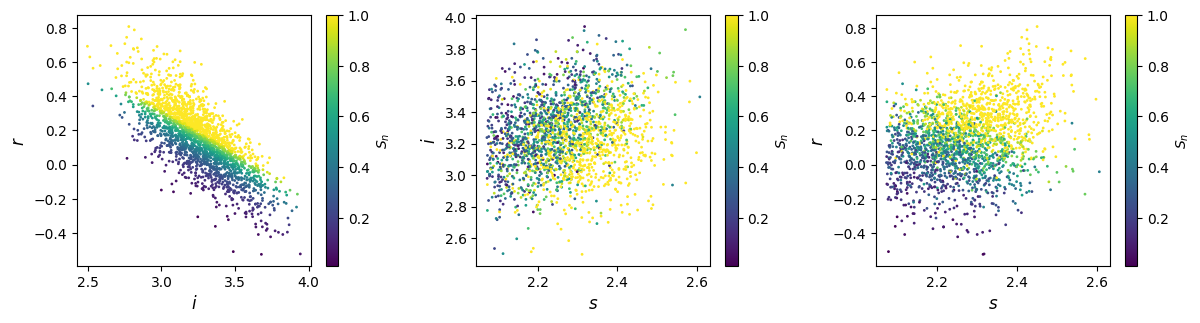

In [20]:
df = pd.read_csv("../data/foundation/fp_sample_final/smin_setting_1/fp_fit_method_1/lamost.csv")

fig, axs = plt.subplots(ncols=3, figsize=(FIGURE_WIDTH * 3 / 2, FIGURE_HEIGHT / 1.5))
combos = [("i", "r"), ("s", "i"), ("s", "r")]
for i, combo in enumerate(combos):
    ax = fig.axes[i]
    col_x, col_y = combo
    scatter = ax.scatter(df[col_x], df[col_y], c=df["Sn"], s=1, cmap='viridis')
    fig.colorbar(scatter, ax=ax, label=r'$S_n$')

    ax.set_xlabel(rf"${col_x}$", fontsize=12)
    ax.set_ylabel(rf"${col_y}$", fontsize=12)

fig.tight_layout()

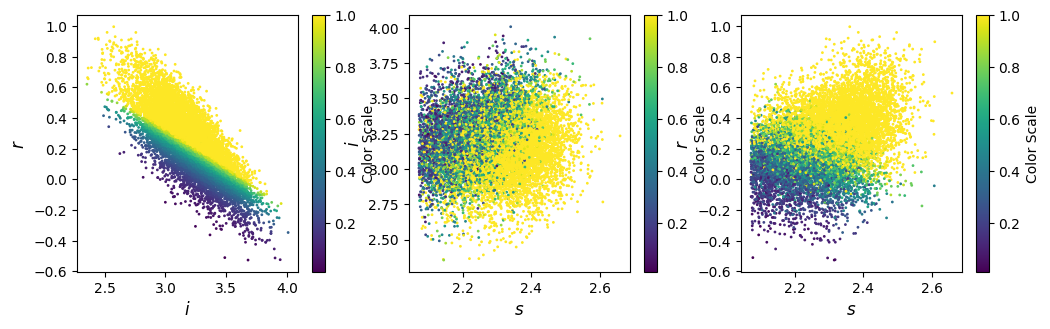

In [36]:
df = pd.read_csv("../data/foundation/fp_sample_final/smin_setting_1/fp_fit_method_1/all_combined.csv")

fig, axs = plt.subplots(ncols=3, figsize=(FIGURE_WIDTH * 3 / 2, FIGURE_HEIGHT / 1.5))
combos = [("i", "r"), ("s", "i"), ("s", "r")]
for i, combo in enumerate(combos):
    ax = fig.axes[i]
    col_x, col_y = combo
    scatter = ax.scatter(df[col_x], df[col_y], c=df["Sn"], s=1, cmap='viridis')
    fig.colorbar(scatter, ax=ax, label='Color Scale')

    ax.set_xlabel(rf"${col_x}$", fontsize=12)
    ax.set_ylabel(rf"${col_y}$", fontsize=12)

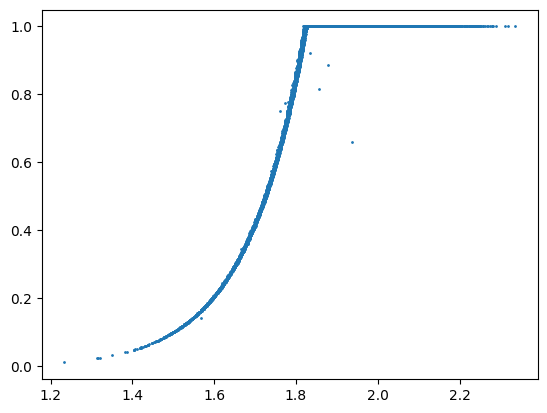

In [39]:
plt.scatter(df["r"] + 0.5 * df["i"], df["Sn"], s=1)